# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [ ]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

In [ ]:
out_dir = out_dir = '../data/out_dev/'

In [ ]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

In [ ]:
del(imgs0)

### Only volume reconstruction for now - SGD

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different

In [ ]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [ ]:
N_epochs = 20
batch_size = 32
step_size = 1000000 # 1e-3

idxrand = np.random.permutation(N)
idx1 = idxrand[:int(N/2)]
idx2 = idxrand[int(N/2):]
             
grad_func1, loss_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); #plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); #plt.colorbar()

In [ ]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

#### FSC

In [ ]:
print(v_rec1.shape)
print(v_rec2.shape)
print(x_grid)

In [ ]:
res, fsc, shell_points = calc_fsc(v_rec1, v_rec2, [1, 128])

In [ ]:
plt.plot(res, fsc)

In [ ]:
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc)

In [ ]:
fsc

In [ ]:
fsc[10]

In [ ]:
fsc[11]

In [ ]:
res_angs[10]

In [ ]:
res_angs[11]

### Newton's method vs GD vs CG

#### GD - a pain to tune 

In [6]:
Ngd = 1000

N_epochs = 200
batch_size = Ngd
step_size = 10000 # 1e-3

idx = np.arange(Ngd)

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

NameError: name 'gradv_obj' is not defined

In [7]:
v_rec_gd, loss_rec_gd, grad_rec_gd = sgd(grad_func, loss_func1, Ngd, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)


NameError: name 'grad_func' is not defined

In [ ]:
plt.plot(loss_rec_gd)

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [8]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

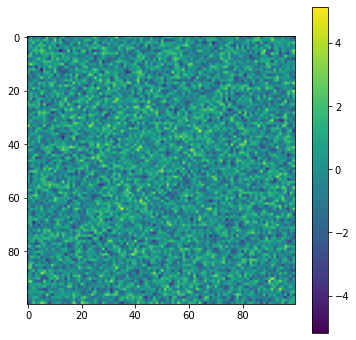

In [9]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [10]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [11]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [12]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [13]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

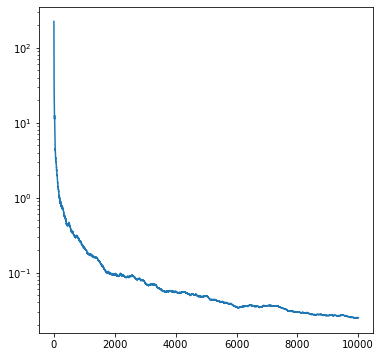

In [14]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [15]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [16]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [17]:
f(x0)

DeviceArray(0., dtype=float64)

In [18]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [20]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

0.01427006721496582
0.0051724910736083984


DeviceArray(0., dtype=float64)

#### Toy problem

Condition number =  3.33e+05


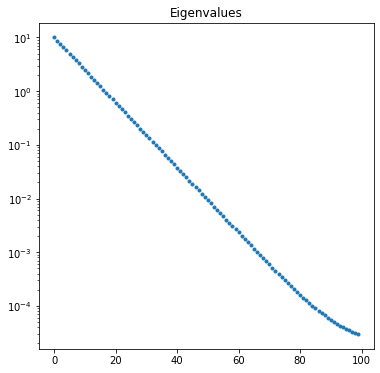

In [58]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [59]:
sig_noise = 1
lam = 0.1

b = A @ x_gt #+ np.random.normal(size=(n,)) * sig_noise

F = jax.jit(lambda x : jnp.sum((A @ x - b)**2) #+ lam * jnp.mean(x**2))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


f(x_gt + 1) = 368.350576936144
f(x_gt) = 0.0
gradF(x_gt) = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
hessianF(x_gt) = [[ 2.54873251  1.83673044 -0.04047574 ...  1.78637264 -2.17478585
   1.85817   ]
 [ 1.83673044  6.68852552 -0.25082722 ...  3.95424303 -6.72520495
   2.24816259]
 [-0.04047574 -0.25082722  2.66000647 ...  2.4149449  -0.49413592
  -2.95257187]
 ...
 [ 1.78637264  3.95424303  2.4149449  ... 15.90393093 -6.35733906
  -3.10244647]
 [-2.17478585 -6.72520495 -0.49413592 ... -6.35733906 12.29887303
  -3.43594311]
 [ 1.85817     2.24816259 -2.95257187 ... -3.10244647 -3.43594311
   7.87121291]]


In [60]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [79]:
N_iter = 10000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

Iter 200: loss = 7.566913023656689
Iter 400: loss = 3.438941198040916
Iter 600: loss = 2.2615039813308515
Iter 800: loss = 1.7908432853399627
Iter 1000: loss = 1.548381362484629
Iter 1200: loss = 1.3950858123764527
Iter 1400: loss = 1.2826627354318219
Iter 1600: loss = 1.1920775288806487
Iter 1800: loss = 1.1149968751782497
Iter 2000: loss = 1.0473650752746044
Iter 2200: loss = 0.9869678775580705
Iter 2400: loss = 0.932445857482305
Iter 2600: loss = 0.8828719133378498
Iter 2800: loss = 0.8375597486135448
Iter 3000: loss = 0.7959712331490839
Iter 3200: loss = 0.7576680543809416
Iter 3400: loss = 0.7222842497654264
Iter 3600: loss = 0.689509193706849
Iter 3800: loss = 0.6590761944261014
Iter 4000: loss = 0.6307543372226019
Iter 4200: loss = 0.6043423540910671
Iter 4400: loss = 0.5796638488097261
Iter 4600: loss = 0.5565634829634496
Iter 4800: loss = 0.5349038749208709
Iter 5000: loss = 0.51456304607797
Iter 5200: loss = 0.49543229772196
Iter 5400: loss = 0.4774144328586791
Iter 5600: los

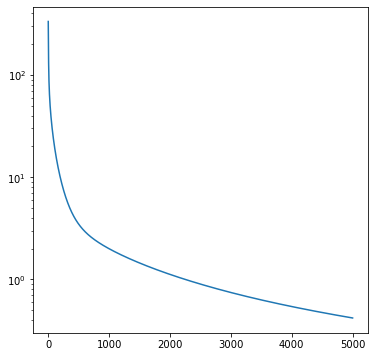

In [78]:
plt.semilogy(loss_gd)

In [80]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

Iter 1: loss = 4.541535870317591e-10
Iter 2: loss = 2.5559399744383823e-22
Iter 3: loss = 1.2011639877154313e-29
Iter 4: loss = 1.4245718612643506e-29
Iter 5: loss = 1.0680437099593855e-29
Iter 6: loss = 1.359937652330715e-29
Iter 7: loss = 1.1528616647101994e-29
Iter 8: loss = 1.1075637924182116e-29
Iter 9: loss = 1.3778102822146285e-29
Iter 10: loss = 1.476417895367255e-29


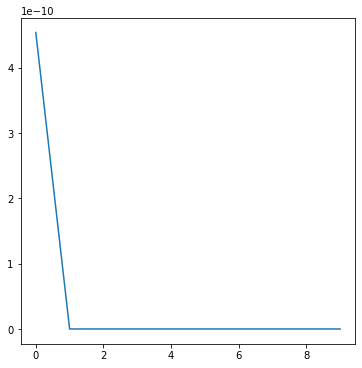

In [81]:
plt.plot(loss_n)

In [83]:
N_iter = 10000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 144.60878098402895
  cg iter 200 ||r|| = 0.02052070984325848
  cg iter 400 ||r|| = 0.00011869604053601819
  cg iter 600 ||r|| = 0.0009661663272870522
  cg iter 800 ||r|| = 0.00022536441892726406
  cg iter 1000 ||r|| = 0.0006928287770301123
  cg iter 1200 ||r|| = 0.00012444674203541985
  cg iter 1400 ||r|| = 5.909981603639233e-05
  cg iter 1600 ||r|| = 2.6552915410393933e-05
  cg iter 1800 ||r|| = 0.00011272503049017578
  cg iter 2000 ||r|| = 4.419069390554162e-05
  cg iter 2200 ||r|| = 2.9743115069315506e-05
  cg iter 2400 ||r|| = 0.0002344880258614505
  cg iter 2600 ||r|| = 5.339460579278025e-05
  cg iter 2800 ||r|| = 6.363079144773662e-05
  cg iter 3000 ||r|| = 2.9888168428041017e-05
  cg iter 3200 ||r|| = 3.342202459982158e-05
  cg iter 3400 ||r|| = 2.945877349379104e-05
  cg iter 3600 ||r|| = 3.6268980707420437e-05
  cg iter 3800 ||r|| = 5.3160438566230884e-05
  cg iter 4000 ||r|| = 2.7660143757230447e-06
  cg iter 4200 ||r|| = 4.50507418724294e-05
  cg iter 440

In [84]:
F(x_cg)

DeviceArray(1.39501801e-08, dtype=float64)

#### OASIS

In [150]:
from tqdm import tqdm 

def oasis(key, F, gradF, hvpF, w0, eta, D0, beta2, alpha, N_epoch = 20, batch_size = None, N = 1, iter_display = 1):
    """OASIS with fixed learning rate, deterministic or stochastic."""
    
    n = w0.shape[0] 
    
    if batch_size is None or batch_size == N:
        N_batch = 1
    else:
        N_batch = N/batch_size
    
    gradFw0 = gradF(w0, jnp.arange(N))
    Dhat0 = jnp.maximum(jnp.abs(D0), alpha)
                      
    invDhat0 = jnp.diag(1/Dhat0)
    w1 = w0 - eta * (invDhat0 @ gradFw0)

    loss_list = []
    for idx_epoch in range(1, N_epoch+1):
        if idx_epoch % iter_display == 0:
            print(f"Epoch {idx_epoch}/{N_epoch}")

        key, subkey1, subkey2 = random.split(key, 3)

        idx_batches_grad = np.array_split(random.permutation(subkey1, N), N_batch)
        idx_batches_hess = np.array_split(random.permutation(subkey2, N), N_batch)
        
        z = random.rademacher(key, (len(idx_batches_grad), n)).astype(jnp.float64)
     
        loss_epoch = []
        if idx_epoch % iter_display == 0:
            pbar = tqdm(range(len(idx_batches_grad)))
        else:
            pbar = range(len(idx_batches_grad))
        for k in pbar:

            D1 = beta2 * D0 + (1-beta2) * (z[k-1] * hvpF(w1, z[k-1], idx_batches_hess[k-1]))
            Dhat1 = jnp.maximum(jnp.abs(D1), alpha)       
            invDhat1 = jnp.diag(1/Dhat1)

            w2 = w1 - eta * (invDhat1 @ gradF(w1, idx_batches_grad[k-1]))

            w0 = w1
            w1 = w2

            loss_iter = F(w1, idx_batches_grad[k-1])
            loss_epoch.append(loss_iter)
            
            if idx_epoch % iter_display == 0:
                pbar.set_postfix(loss = f"{loss_iter : .3e}")
                
        loss_epoch = jnp.mean(jnp.array(loss_epoch))
        loss_list.append(loss_epoch)
        
        if idx_epoch % iter_display == 0:
            print(f"  Loss = {loss_epoch : .3e}")
        
    return w1, jnp.array(loss_list)


In [151]:
def oasis_adaptive(key, F, gradF, hvpF, w0, eta0, D0, beta2, alpha, N_epoch = 20, batch_size = None, N = 1, iter_display = 1):
    """OASIS with adaptive learning rate, deterministic and stochastic."""

    n = w0.shape[0] 
    
    if batch_size is None or batch_size == N:
        N_batch = 1
    else:
        N_batch = N/batch_size
    
    gradFw0 = gradF(w0, jnp.arange(N))
    theta0 = jnp.inf
    Dhat0 = jnp.maximum(jnp.abs(D0), alpha)
                        
    invDhat0 = jnp.diag(1/Dhat0)
    w1 = w0 - eta0 * (invDhat0 @ gradFw0)
    
    gradFw1 = gradF(w1, jnp.arange(N))

    loss_list = []
    for idx_epoch in range(1, N_epoch+1):
        if idx_epoch % iter_display == 0:
            print(f"Epoch {idx_epoch}/{N_epoch}")

        key, subkey1, subkey2 = random.split(key, 3)

        idx_batches_grad = np.array_split(random.permutation(subkey1, N), N_batch)
        idx_batches_hess = np.array_split(random.permutation(subkey2, N), N_batch)
        
        z = random.rademacher(key, (len(idx_batches_grad), n)).astype(jnp.float64)
     
        loss_epoch = []
        if idx_epoch % iter_display == 0:
            pbar = tqdm(range(len(idx_batches_grad)))
        else:
            pbar = range(len(idx_batches_grad))
        for k in pbar:
            
            D1 = beta2 * D0 + (1-beta2) * (z[k-1] * hvpF(w1, z[k-1], idx_batches_hess[k-1]))

            Dhat1 = jnp.maximum(jnp.abs(D1), alpha)
            invDhat1 = jnp.diag(1/Dhat1)
            Dhat1 = jnp.diag(Dhat1)

            tl = jnp.sqrt(1 + theta0)*eta0

            gradFw1 = gradF(w1, idx_batches_grad[k-1])
            gradFw0 = gradF(w0, idx_batches_grad[k-1])

            wd = w1-w0
            gfd = gradFw1 - gradFw0
            tr = 1/2 * jnp.sqrt(jnp.vdot(wd, Dhat1 @ wd) / jnp.vdot(gfd, invDhat1 @ gfd))

            eta1 = jnp.minimum(tl, tr)

            w2 = w1 - eta1 * (invDhat1 @ gradFw1)
            gradFw2 = gradF(w2, idx_batches_grad[k-1])

            theta1 = eta1/eta0

            w0 = w1
            w1 = w2

            eta0 = eta1
            theta0 = theta1

            loss_iter = F(w1, idx_batches_grad[k-1])
            loss_epoch.append(loss_iter) 

            if idx_epoch % iter_display == 0:
                pbar.set_postfix(loss = f"{loss_iter : .3e}")
            
        loss_epoch = jnp.mean(jnp.array(loss_epoch))
        loss_list.append(loss_epoch)
        
        if idx_epoch % iter_display == 0:
            print(f"  Loss = {loss_epoch : .3e}")            
            
    return w1, jnp.array(loss_list)

In [94]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [101]:
N_iter = 10000
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 200)


Epoch 200/10000


100%|██████████| 1/1 [00:00<00:00, 70.86it/s, loss=5.524]

  Loss =  5.524


Epoch 400/10000


100%|██████████| 1/1 [00:00<00:00, 58.73it/s, loss=2.416]

  Loss =  2.416


Epoch 600/10000


100%|██████████| 1/1 [00:00<00:00, 75.42it/s, loss=1.703]

  Loss =  1.703


Epoch 800/10000


100%|██████████| 1/1 [00:00<00:00, 69.70it/s, loss=1.419]

  Loss =  1.419


Epoch 1000/10000


100%|██████████| 1/1 [00:00<00:00, 55.95it/s, loss=1.252]

  Loss =  1.252


Epoch 1200/10000


100%|██████████| 1/1 [00:00<00:00, 59.97it/s, loss=1.129]

  Loss =  1.129


Epoch 1400/10000


100%|██████████| 1/1 [00:00<00:00, 68.57it/s, loss=1.029]

  Loss =  1.029


Epoch 1600/10000


100%|██████████| 1/1 [00:00<00:00, 62.21it/s, loss=0.944]

  Loss =  0.944


Epoch 1800/10000


100%|██████████| 1/1 [00:00<00:00, 56.31it/s, loss=0.869]

  Loss =  0.869


Epoch 2000/10000


100%|██████████| 1/1 [00:00<00:00, 80.27it/s, loss=0.804]

  Loss =  0.804


Epoch 2200/10000


100%|██████████| 1/1 [00:00<00:00, 51.63it/s, loss=0.746]

  Loss =  0.746


Epoch 2400/10000


100%|██████████| 1/1 [00:00<00:00, 62.85it/s, loss=0.694]

  Loss =  0.694


Epoch 2600/10000


100%|██████████| 1/1 [00:00<00:00, 59.34it/s, loss=0.648]

  Loss =  0.648


Epoch 2800/10000


100%|██████████| 1/1 [00:00<00:00, 68.16it/s, loss=0.606]

  Loss =  0.606


Epoch 3000/10000


100%|██████████| 1/1 [00:00<00:00, 52.69it/s, loss=0.568]

  Loss =  0.568


Epoch 3200/10000


100%|██████████| 1/1 [00:00<00:00, 60.86it/s, loss=0.534]

  Loss =  0.534


Epoch 3400/10000


100%|██████████| 1/1 [00:00<00:00, 69.69it/s, loss=0.503]

  Loss =  0.503


Epoch 3600/10000


100%|██████████| 1/1 [00:00<00:00, 52.72it/s, loss=0.475]

  Loss =  0.475


Epoch 3800/10000


100%|██████████| 1/1 [00:00<00:00, 56.53it/s, loss=0.449]

  Loss =  0.449


Epoch 4000/10000


100%|██████████| 1/1 [00:00<00:00, 84.18it/s, loss=0.426]

  Loss =  0.426


Epoch 4200/10000


100%|██████████| 1/1 [00:00<00:00, 55.71it/s, loss=0.404]

  Loss =  0.404


Epoch 4400/10000


100%|██████████| 1/1 [00:00<00:00, 66.85it/s, loss=0.384]

  Loss =  0.384


Epoch 4600/10000


100%|██████████| 1/1 [00:00<00:00, 71.71it/s, loss=0.366]

  Loss =  0.366


Epoch 4800/10000


100%|██████████| 1/1 [00:00<00:00, 60.01it/s, loss=0.349]

  Loss =  0.349


Epoch 5000/10000


100%|██████████| 1/1 [00:00<00:00, 74.13it/s, loss=0.334]

  Loss =  0.334


Epoch 5200/10000


100%|██████████| 1/1 [00:00<00:00, 66.20it/s, loss=0.319]

  Loss =  0.319


Epoch 5400/10000


100%|██████████| 1/1 [00:00<00:00, 61.56it/s, loss=0.306]

  Loss =  0.306


Epoch 5600/10000


100%|██████████| 1/1 [00:00<00:00, 62.22it/s, loss=0.293]

  Loss =  0.293


Epoch 5800/10000


100%|██████████| 1/1 [00:00<00:00, 68.27it/s, loss=0.281]

  Loss =  0.281


Epoch 6000/10000


100%|██████████| 1/1 [00:00<00:00, 60.97it/s, loss=0.270]

  Loss =  0.270


Epoch 6200/10000


100%|██████████| 1/1 [00:00<00:00, 79.07it/s, loss=0.260]

  Loss =  0.260


Epoch 6400/10000


100%|██████████| 1/1 [00:00<00:00, 57.40it/s, loss=0.250]

  Loss =  0.250


Epoch 6600/10000


100%|██████████| 1/1 [00:00<00:00, 58.73it/s, loss=0.242]

  Loss =  0.242


Epoch 6800/10000


100%|██████████| 1/1 [00:00<00:00, 71.26it/s, loss=0.233]

  Loss =  0.233


Epoch 7000/10000


100%|██████████| 1/1 [00:00<00:00, 71.26it/s, loss=0.225]

  Loss =  0.225


Epoch 7200/10000


100%|██████████| 1/1 [00:00<00:00, 40.63it/s, loss=0.218]

  Loss =  0.218


Epoch 7400/10000


100%|██████████| 1/1 [00:00<00:00, 59.72it/s, loss=0.210]

  Loss =  0.210


Epoch 7600/10000


100%|██████████| 1/1 [00:00<00:00, 61.67it/s, loss=0.204]

  Loss =  0.204


Epoch 7800/10000


100%|██████████| 1/1 [00:00<00:00, 42.39it/s, loss=0.197]

  Loss =  0.197


Epoch 8000/10000


100%|██████████| 1/1 [00:00<00:00, 59.84it/s, loss=0.191]

  Loss =  0.191


Epoch 8200/10000


100%|██████████| 1/1 [00:00<00:00, 66.47it/s, loss=0.186]

  Loss =  0.186


Epoch 8400/10000


100%|██████████| 1/1 [00:00<00:00, 52.44it/s, loss=0.180]

  Loss =  0.180


Epoch 8600/10000


100%|██████████| 1/1 [00:00<00:00, 60.46it/s, loss=0.175]

  Loss =  0.175


Epoch 8800/10000


100%|██████████| 1/1 [00:00<00:00, 64.33it/s, loss=0.170]

  Loss =  0.170


Epoch 9000/10000


100%|██████████| 1/1 [00:00<00:00, 73.20it/s, loss=0.166]

  Loss =  0.166


Epoch 9200/10000


100%|██████████| 1/1 [00:00<00:00, 55.63it/s, loss=0.161]

  Loss =  0.161


Epoch 9400/10000


100%|██████████| 1/1 [00:00<00:00, 49.78it/s, loss=0.157]

  Loss =  0.157


Epoch 9600/10000


100%|██████████| 1/1 [00:00<00:00, 70.18it/s, loss=0.153]

  Loss =  0.153


Epoch 9800/10000


100%|██████████| 1/1 [00:00<00:00, 52.81it/s, loss=0.149]

  Loss =  0.149


Epoch 10000/10000


100%|██████████| 1/1 [00:00<00:00, 60.35it/s, loss=0.145]

  Loss =  0.145


In [104]:
N_iter = 10000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 200)


Epoch 200/10000


100%|██████████| 1/1 [00:00<00:00, 45.13it/s, loss=0.603]

  Loss =  0.603


Epoch 400/10000


100%|██████████| 1/1 [00:00<00:00, 46.93it/s, loss=0.287]

  Loss =  0.287


Epoch 600/10000


100%|██████████| 1/1 [00:00<00:00, 38.75it/s, loss=0.174]

  Loss =  0.174


Epoch 800/10000


100%|██████████| 1/1 [00:00<00:00, 43.67it/s, loss=0.119]

  Loss =  0.119


Epoch 1000/10000


100%|██████████| 1/1 [00:00<00:00, 41.63it/s, loss=0.090]

  Loss =  0.090


Epoch 1200/10000


100%|██████████| 1/1 [00:00<00:00, 42.01it/s, loss=0.072]

  Loss =  0.072


Epoch 1400/10000


100%|██████████| 1/1 [00:00<00:00, 38.11it/s, loss=0.059]

  Loss =  0.059


Epoch 1600/10000


100%|██████████| 1/1 [00:00<00:00, 43.95it/s, loss=0.051]

  Loss =  0.051


Epoch 1800/10000


100%|██████████| 1/1 [00:00<00:00, 38.19it/s, loss=0.044]

  Loss =  0.044


Epoch 2000/10000


100%|██████████| 1/1 [00:00<00:00, 49.55it/s, loss=0.040]

  Loss =  0.040


Epoch 2200/10000


100%|██████████| 1/1 [00:00<00:00, 51.90it/s, loss=0.036]

  Loss =  0.036


Epoch 2400/10000


100%|██████████| 1/1 [00:00<00:00, 40.55it/s, loss=0.034]

  Loss =  0.034


Epoch 2600/10000


100%|██████████| 1/1 [00:00<00:00, 34.76it/s, loss=0.031]

  Loss =  0.031


Epoch 2800/10000


100%|██████████| 1/1 [00:00<00:00, 48.89it/s, loss=0.030]

  Loss =  0.030


Epoch 3000/10000


100%|██████████| 1/1 [00:00<00:00, 50.28it/s, loss=0.028]

  Loss =  0.028


Epoch 3200/10000


100%|██████████| 1/1 [00:00<00:00, 48.49it/s, loss=0.026]

  Loss =  0.026


Epoch 3400/10000


100%|██████████| 1/1 [00:00<00:00, 50.73it/s, loss=0.025]

  Loss =  0.025


Epoch 3600/10000


100%|██████████| 1/1 [00:00<00:00, 40.42it/s, loss=0.024]

  Loss =  0.024


Epoch 3800/10000


100%|██████████| 1/1 [00:00<00:00, 39.65it/s, loss=0.023]

  Loss =  0.023


Epoch 4000/10000


100%|██████████| 1/1 [00:00<00:00, 48.02it/s, loss=0.022]

  Loss =  0.022


Epoch 4200/10000


100%|██████████| 1/1 [00:00<00:00, 44.75it/s, loss=0.021]

  Loss =  0.021


Epoch 4400/10000


100%|██████████| 1/1 [00:00<00:00, 42.83it/s, loss=0.020]

  Loss =  0.020


Epoch 4600/10000


100%|██████████| 1/1 [00:00<00:00, 47.32it/s, loss=0.020]

  Loss =  0.020


Epoch 4800/10000


100%|██████████| 1/1 [00:00<00:00, 42.93it/s, loss=0.019]

  Loss =  0.019


Epoch 5000/10000


100%|██████████| 1/1 [00:00<00:00, 45.93it/s, loss=0.018]

  Loss =  0.018


Epoch 5200/10000


100%|██████████| 1/1 [00:00<00:00, 50.13it/s, loss=0.018]

  Loss =  0.018


Epoch 5400/10000


100%|██████████| 1/1 [00:00<00:00, 40.30it/s, loss=0.017]

  Loss =  0.017


Epoch 5600/10000


100%|██████████| 1/1 [00:00<00:00, 45.58it/s, loss=0.017]

  Loss =  0.017


Epoch 5800/10000


100%|██████████| 1/1 [00:00<00:00, 44.41it/s, loss=0.016]

  Loss =  0.016


Epoch 6000/10000


100%|██████████| 1/1 [00:00<00:00, 43.33it/s, loss=0.016]

  Loss =  0.016


Epoch 6200/10000


100%|██████████| 1/1 [00:00<00:00, 50.56it/s, loss=0.016]

  Loss =  0.016


Epoch 6400/10000


100%|██████████| 1/1 [00:00<00:00, 30.11it/s, loss=0.015]

  Loss =  0.015


Epoch 6600/10000


100%|██████████| 1/1 [00:00<00:00, 45.04it/s, loss=0.015]

  Loss =  0.015


Epoch 6800/10000


100%|██████████| 1/1 [00:00<00:00, 37.95it/s, loss=0.014]

  Loss =  0.014


Epoch 7000/10000


100%|██████████| 1/1 [00:00<00:00, 41.76it/s, loss=0.014]

  Loss =  0.014


Epoch 7200/10000


100%|██████████| 1/1 [00:00<00:00, 42.41it/s, loss=0.014]

  Loss =  0.014


Epoch 7400/10000


100%|██████████| 1/1 [00:00<00:00, 46.31it/s, loss=0.013]

  Loss =  0.013


Epoch 7600/10000


100%|██████████| 1/1 [00:00<00:00, 50.51it/s, loss=0.013]

  Loss =  0.013


Epoch 7800/10000


100%|██████████| 1/1 [00:00<00:00, 48.42it/s, loss=0.013]

  Loss =  0.013


Epoch 8000/10000


100%|██████████| 1/1 [00:00<00:00, 51.65it/s, loss=0.013]

  Loss =  0.013


Epoch 8200/10000


100%|██████████| 1/1 [00:00<00:00, 46.68it/s, loss=0.012]

  Loss =  0.012


Epoch 8400/10000


100%|██████████| 1/1 [00:00<00:00, 42.47it/s, loss=0.012]

  Loss =  0.012


Epoch 8600/10000


100%|██████████| 1/1 [00:00<00:00, 40.03it/s, loss=0.012]

  Loss =  0.012


Epoch 8800/10000


100%|██████████| 1/1 [00:00<00:00, 46.65it/s, loss=0.012]

  Loss =  0.012


Epoch 9000/10000


100%|██████████| 1/1 [00:00<00:00, 42.78it/s, loss=0.011]

  Loss =  0.011


Epoch 9200/10000


100%|██████████| 1/1 [00:00<00:00, 44.88it/s, loss=0.011]

  Loss =  0.011


Epoch 9400/10000


100%|██████████| 1/1 [00:00<00:00, 40.26it/s, loss=0.011]

  Loss =  0.011


Epoch 9600/10000


100%|██████████| 1/1 [00:00<00:00, 48.46it/s, loss=0.011]

  Loss =  0.011


Epoch 9800/10000


100%|██████████| 1/1 [00:00<00:00, 40.04it/s, loss=0.010]

  Loss =  0.010


Epoch 10000/10000


100%|██████████| 1/1 [00:00<00:00, 45.38it/s, loss=0.010]

  Loss =  0.010


9.999029382257163e-12
0.6624434100332252
4.437255648421646
4.3870623423255015
3.8426731608818705


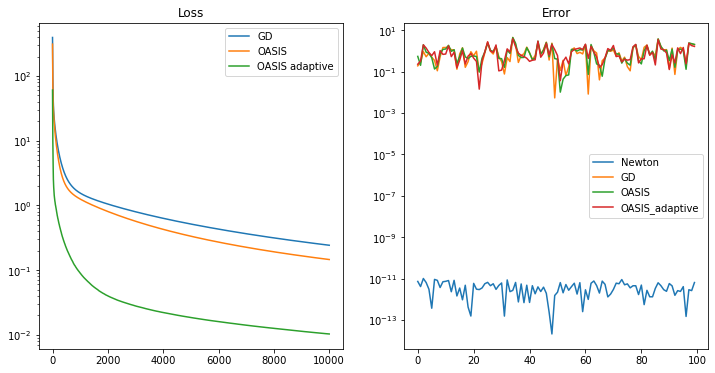

In [114]:
print(jnp.max(jnp.abs(x_gt-x_n)))
print(jnp.max(jnp.abs(x_gt-x_cg)))
print(jnp.max(jnp.abs(x_gt-x_gd)))
print(jnp.max(jnp.abs(x_gt-x_o)))
print(jnp.max(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

#plt.semilogy(loss_n)
plt.semilogy(loss_gd)
plt.semilogy(loss_o)
plt.semilogy(loss_oa)
plt.legend(["GD", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["Newton", "GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

Generate $N$ operators to create a loss function to do SGD/OASIS on:

In [368]:
n = 100
N = 1000

x_gt = np.random.normal(size=(n,))

ops = []
b = []
for i in range(N):
    A = np.random.normal(size=(n,n))
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.flip(jnp.logspace(-5,4,n)) + np.random.normal(size=(n,))*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [370]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

 3.35e+02


In [371]:
def loss_term(x, A, b):
    return 1/2 * jnp.mean((A@x - b)**2)

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [372]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

0.0
0.0
(100,)
(100,)
(100,)
(100,)


In [373]:
Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = jnp.array(np.random.randn(n))

In [386]:
N_epoch = 100
beta2 = 0.99
eta = 10000 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 10)

Epoch 10/100


100%|██████████| 50/50 [00:00<00:00, 143.41it/s, loss=2.573e-03]


  Loss =  6.562e-03
Epoch 20/100


100%|██████████| 50/50 [00:00<00:00, 138.43it/s, loss=1.074e-10]


  Loss =  3.217e-10
Epoch 30/100


100%|██████████| 50/50 [00:00<00:00, 139.56it/s, loss=7.820e-18]


  Loss =  1.962e-17
Epoch 40/100


100%|██████████| 50/50 [00:00<00:00, 144.53it/s, loss=8.484e-25]


  Loss =  1.661e-24
Epoch 50/100


100%|██████████| 50/50 [00:00<00:00, 145.69it/s, loss=3.115e-25]


  Loss =  3.183e-25
Epoch 60/100


100%|██████████| 50/50 [00:00<00:00, 141.19it/s, loss=3.149e-25]


  Loss =  3.102e-25
Epoch 70/100


100%|██████████| 50/50 [00:00<00:00, 143.59it/s, loss=3.147e-25]


  Loss =  3.054e-25
Epoch 80/100


100%|██████████| 50/50 [00:00<00:00, 145.16it/s, loss=2.964e-25]


  Loss =  3.026e-25
Epoch 90/100


100%|██████████| 50/50 [00:00<00:00, 150.29it/s, loss=2.974e-25]


  Loss =  3.006e-25
Epoch 100/100


100%|██████████| 50/50 [00:00<00:00, 140.40it/s, loss=2.784e-25]


  Loss =  3.044e-25


In [385]:
N_epoch = 100
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 10)


Epoch 10/100


100%|██████████| 50/50 [00:00<00:00, 123.29it/s, loss=1.002e-08]


  Loss =  7.020e-08
Epoch 20/100


100%|██████████| 50/50 [00:00<00:00, 115.75it/s, loss=1.134e-20]


  Loss =  5.356e-20
Epoch 30/100


100%|██████████| 50/50 [00:00<00:00, 125.41it/s, loss=7.079e-26]


  Loss =  7.360e-26
Epoch 40/100


100%|██████████| 50/50 [00:00<00:00, 121.88it/s, loss=7.671e-26]


  Loss =  6.564e-26
Epoch 50/100


100%|██████████| 50/50 [00:00<00:00, 114.83it/s, loss=6.169e-26]


  Loss =  6.471e-26
Epoch 60/100


100%|██████████| 50/50 [00:00<00:00, 115.35it/s, loss=5.445e-26]


  Loss =  5.652e-26
Epoch 70/100


100%|██████████| 50/50 [00:00<00:00, 128.60it/s, loss=5.625e-26]


  Loss =  5.582e-26
Epoch 80/100


100%|██████████| 50/50 [00:00<00:00, 124.17it/s, loss=5.613e-26]


  Loss =  5.721e-26
Epoch 90/100


100%|██████████| 50/50 [00:00<00:00, 124.42it/s, loss=5.468e-26]


  Loss =  5.565e-26
Epoch 100/100


100%|██████████| 50/50 [00:00<00:00, 119.57it/s, loss=5.812e-26]


  Loss =  5.362e-26


In [ ]:
N_epoch = 10
beta2 = 0.99
eta = 1e4 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

In [ ]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


In [384]:
N_epoch = 100
beta2 = 0.99
eta = 1e-6
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 10)

Epoch 1/100 

100%|██████████| 50/50 [00:00<00:00, 508.88it/s, grad=3.138e+04, loss=1.100e+05]

  |Grad| = 8.121e+04
  Loss = 7.796e+05


Epoch 11/100 

100%|██████████| 50/50 [00:00<00:00, 534.09it/s, grad=5.199e-01, loss=3.357e-05]

  |Grad| = 8.785e-01
  Loss = 1.197e-04


Epoch 21/100 

100%|██████████| 50/50 [00:00<00:00, 475.01it/s, grad=2.255e-05, loss=6.631e-14]

  |Grad| = 3.288e-05
  Loss = 1.755e-13


Epoch 31/100 

100%|██████████| 50/50 [00:00<00:00, 559.84it/s, grad=7.508e-10, loss=1.104e-22]

  |Grad| = 1.495e-09
  Loss = 3.753e-22


Epoch 41/100 

100%|██████████| 50/50 [00:00<00:00, 543.27it/s, grad=1.640e-10, loss=1.419e-24]

  |Grad| = 1.385e-10
  Loss = 1.432e-24


Epoch 51/100 

100%|██████████| 50/50 [00:00<00:00, 435.30it/s, grad=1.679e-10, loss=1.431e-24]

  |Grad| = 1.338e-10
  Loss = 1.318e-24


Epoch 61/100 

100%|██████████| 50/50 [00:00<00:00, 584.13it/s, grad=1.346e-10, loss=1.319e-24]

  |Grad| = 1.342e-10
  Loss = 1.269e-24


Epoch 71/100 

100%|██████████| 50/50 [00:00<00:00, 536.16it/s, grad=1.143e-10, loss=9.714e-25]

  |Grad| = 1.367e-10
  Loss = 1.208e-24


Epoch 81/100 

100%|██████████| 50/50 [00:00<00:00, 527.98it/s, grad=1.420e-10, loss=1.192e-24]

  |Grad| = 1.335e-10
  Loss = 1.181e-24


Epoch 91/100 

100%|██████████| 50/50 [00:00<00:00, 501.39it/s, grad=1.554e-10, loss=1.150e-24]

  |Grad| = 1.353e-10
  Loss = 1.157e-24


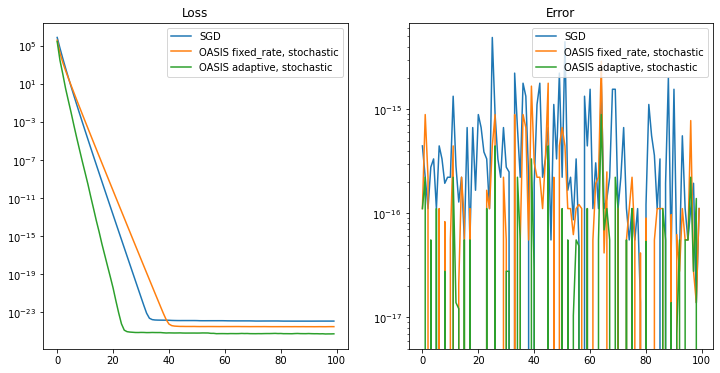

In [388]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
#plt.semilogy(loss_o)
plt.semilogy(loss_os)
#plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* Add noise and rerun all the experiments
* Make the Hessian illconditioned rather than the operator(s) $A$
* Implement some kind of warm up /estimation of $D_0$